# Bereitstellung von Chemikalien I

Die Pharmafirma Boring International möchte die Versorgung ihres Betriebsgeländes mit chemischen Rohstoffen von einem Außenlager optimieren. Jeder Tag ist eingeteilt in gewisse Zeiteinheiten. Zu jeder Zeiteinheit kann ein Bedarf an einem bestimmten Rohstoff auf dem Betriebsgelände vorliegen. Um den Bedarf zu decken, verkehrt ein Lastwagen zwischen Außenlager und Betriebsgelände. Rohstoffe, die der Lastwagen transportiert, können entweder direkt genutzt werden, um den Bedarf zu befriedigen, oder sie können zwischengelagert werden, um einen späteren Bedarf zu decken. Das Zwischenlager hat eine begrenzte Lagerkapazität, der Lastwagen hat ebenfalls eine beschränkte Transportkapazität. Das Außenlager ist nah: Der Lastwagen kann jede Zeiteinheit eine Lieferung machen. 

Jede Fahrt verursacht Kosten. Diese sollen minimiert werden.

Jede Instanz ist durch folgende Daten charakterisiert: 
* Die Menge der Rohstoffe (Chemikalien): $\mathcal C$
* Kapazität des Zwischenlagers: $B$
* Die Zeitperioden: $1,...,T$
* Bedarf zum Zeitpunkt $t$ an Rohstoff $c$: $d_{ct}$</li>
* Kosten einer Fahrt: $g$ 
* Kapazität des Lieferwagens: $h$


Variablen:
* $z_t\in\{0,1\}$: Indikator, ob zum Zeitpunkt $t$ eine Lieferung stattfindet
* $x_{ct}\geq 0$: Menge an Rohstoff $c$, der zu Beginn von Periode $t$ angeliefert wird
* $p_{ct}\geq 0$: Menge an Rohstoff $c$, der zum Ende von Periode $t$ im Zwischenlager vorhanden ist

\begin{align}
\min\, & g\sum_{t=1}^T z_t & (1)\\
& \sum_{c\in\mathcal C} p_{ct}\leq B\quad\text{für alle }t=1,\ldots T & (2) \\
& \sum_{c\in\mathcal C}x_{ct}\leq hz_t\quad\text{für alle }t=1,\ldots T& (3)  \\
& p_{ct} + d_{ct} = p_{c,t-1}+x_{ct}\quad\text{für alle } t=1,\ldots T,c\in\mathcal C & (4)\\
& p_{c0} =0 & (5) 
\end{align}


Wir laden nötige Dateien und machen zwei nötige <code>import</code>. Die Ausgabe wird kompliziert aussehen -- einfach ignorieren! Wenn Sie lokal auf Ihrem Rechner arbeiten, mip installiert haben und chm.py in das gleiche Verzeichnis gelegt haben, kommentieren Sie die ersten beiden Zeilen aus. 

In [1]:
!wget -q https://raw.githubusercontent.com/henningbruhn/mobp/main/chem_aufgabe/chm.py
!pip install mip
    
import mip   ## Der mip-solver
import chm   ## Code zur Instanzenerzeugung und zur graphischen Darstellung

Wir beschaffen uns die Instanz <code>inst</code>, mit der Sie arbeiten sollen.

In [2]:
inst=chm.get_instance1()
print(inst)

C Anzahl Rohstoffe: ...................3
T Anzahl Zeitperioden: ................11
B Kapazität des Zwischenlagers: .......100
g Kosten einer Fahrt: .................1
h Kapazität des Lastwagens: ...........50
d Gesamtbedarf über alle Zeitperioden: 196.0



Die Buchstaben vor den einzelnen Parameter erlauben es auf die jeweiligen Parameter zuzugreifen. ZB kann die Anzahl der Rohstoffe durch <code>inst.C</code> abgegriffen werden. Schauen wir uns einmal den Bedarf an:

In [3]:
inst.d

[[0.0, 0.0, 0.0, 0.0, 45.0, 0.0, 12.0, 0.0, 0.0, 0.0, 6.0],
 [0.0, 0.0, 0.0, 0.0, 22.0, 0.0, 0.0, 20.0, 0.0, 19.0, 0.0],
 [0.0, 0.0, 0.0, 13.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 48.0]]

Der Bedarf ist so abgespeichert, dass <code>inst.d[c][t]</code> den Bedarf des Rohstoffs <code>c</code> zum Zeitpunkt <code>t</code> beziffert.

Es gibt auch eine Funktion, um den Bedarf graphisch darzustellen. Die Rohstoffe sind dabei willkürlich mit Namen echter Chemikalien versehen. 

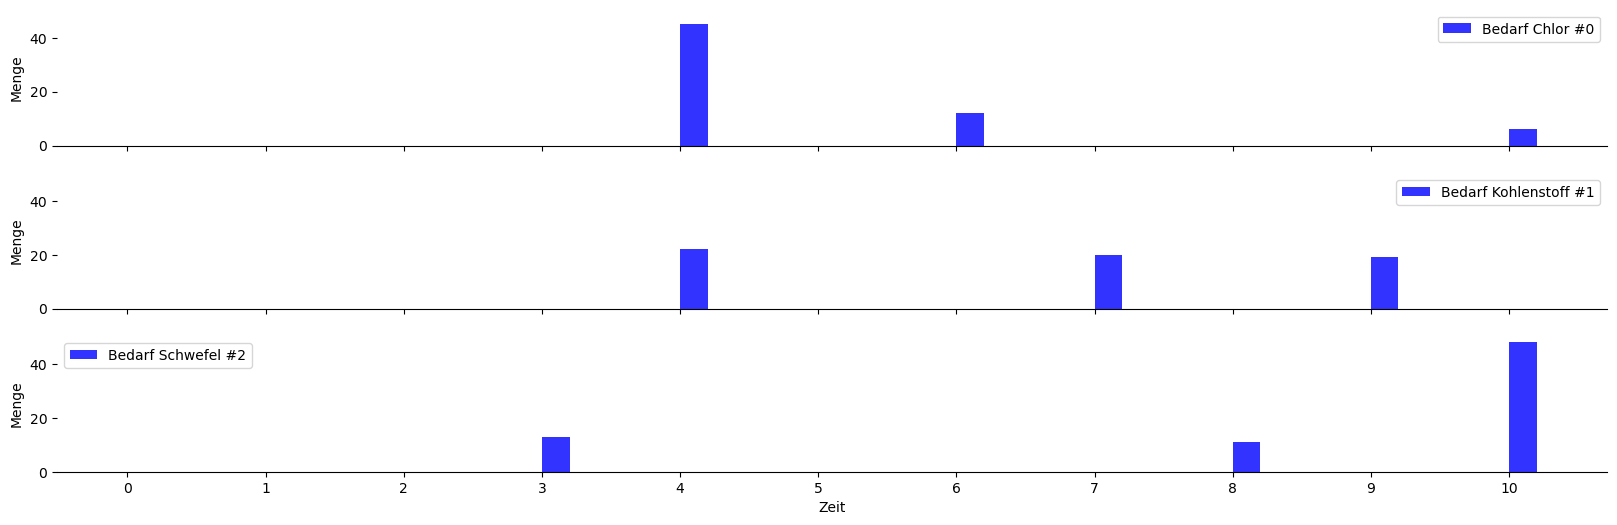

In [4]:
chm.show_demand(inst)

Wir starten mit den Variablen:

In [5]:
m=mip.Model()
p=[[m.add_var() for _ in range(inst.T)] for _ in range(inst.C)]
x=[[m.add_var() for _ in range(inst.T)] for _ in range(inst.C)]
z=[m.add_var(var_type=mip.BINARY) for _ in range(inst.T)]

Die Bedingung (2). Zu beachten ist, dass hier die Zeitperioden $0,...,T-1$ sind, da python gerne mit $0$ anfängt zu zählen.

In [6]:
for t in range(inst.T):
    m+=mip.xsum(p[c][t] for c in range(inst.C))<=inst.B

Bedingung (3):

In [7]:
for t in range(inst.T):
    m+=mip.xsum(x[c][t] for c in range(inst.C))<=z[t]*inst.h

Bedingungen (4) und (5). Dabei ist (5) ersetzt durch eine Sonderform von (4):

In [8]:
for c in range(inst.C):
    m+=p[c][0]+inst.d[c][0]==x[c][0]
for t in range(1,inst.T):
    for c in range(inst.C):
        m+=p[c][t]+inst.d[c][t]==p[c][t-1]+x[c][t]

Die Zielfunktion (1):

In [9]:
m.objective=mip.minimize(mip.xsum(inst.g*z[t] for t in range(inst.T)))

Die Optimierung selbst starten wir mit <code>optimize</code>. Wir lassen uns auch den Optimierungsstatus und die Gesamtkosten ausgeben.

In [10]:
m.verbose=0 # suppress solver output
opt_status=m.optimize()
print("opt status: {}".format(opt_status))
print("Gesamtkosten: {}".format(m.objective_value))

opt status: OptimizationStatus.OPTIMAL
Gesamtkosten: 4.0


Graphische Darstellung der Lösung. Indem Sie <code>chemical</code> auf die Werte der Rohstoffe setzen (zB <code>chemical=1</code>) können Sie sich auch Bedarf/Lagerstand/Lieferungen für die einzelnen Rohstoffe anzeigen lassen.

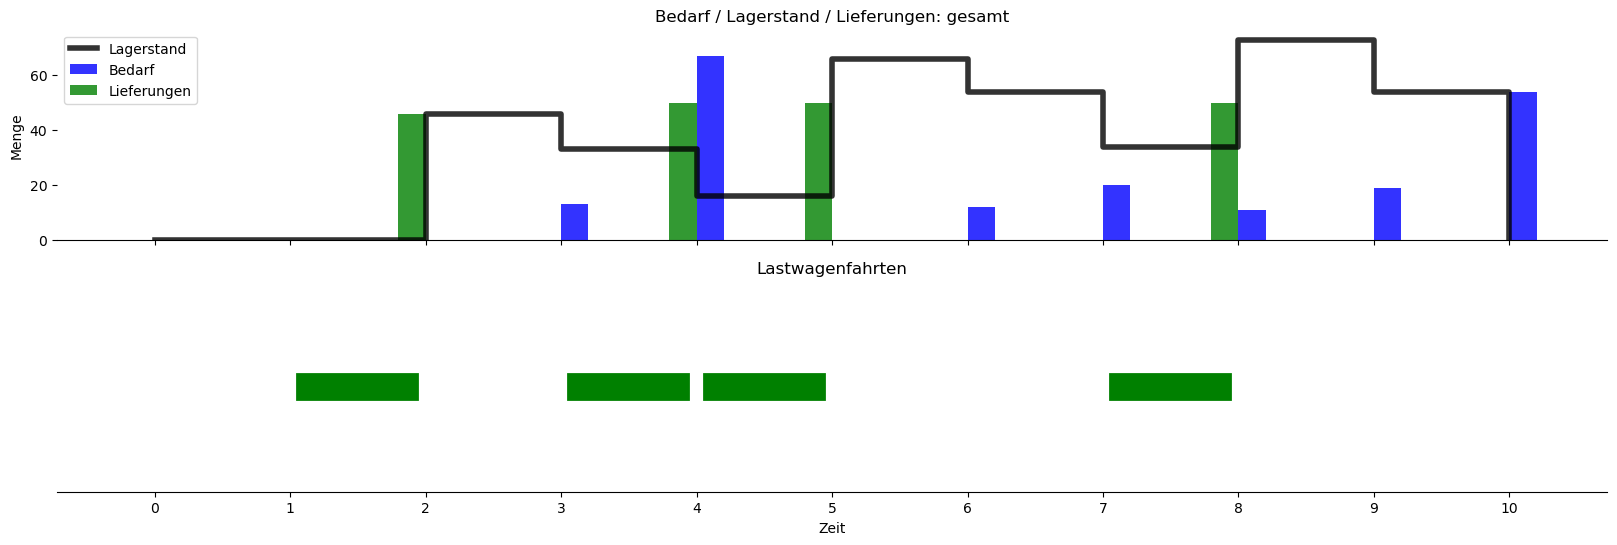

In [11]:
chm.show_solution1(x,z,p,inst,chemical='all')